In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import os
import math
import datetime

In [2]:
%matplotlib inline
np.random.seed(0) # so things are 'random'

# Functions

In [3]:
def get_evaluation_metrics(y_true, y_pred, model_type=None):
    if model_type: 
        print("Model Type: {}".format(model_type))
    print("\tMSE: {:.4f}".format(mean_squared_error(y_true, y_pred)))
    print("\tRMSE: {:.4f}".format(math.sqrt(mean_squared_error(y_true, y_pred))))
    print("\tExplained Variance Score: {:.4f}".format(explained_variance_score(y_true, y_pred)))
    print("\tMAE: {:.4f}\n==========".format(mean_absolute_error(y_true, y_pred)))
    
def get_data_split_by_ticker(feature_set):
    aapl = feature_set.loc[feature_set["ticker_symbol"]=="AAPL"]
    amzn = feature_set.loc[feature_set["ticker_symbol"]=="AMZN"]
    goog = feature_set.loc[feature_set["ticker_symbol"]=="GOOG"]
    googl = feature_set.loc[feature_set["ticker_symbol"]=="GOOGL"]
    msft = feature_set.loc[feature_set["ticker_symbol"]=="MSFT"]
    tsla = feature_set.loc[feature_set["ticker_symbol"]=="TSLA"]
    return aapl, amzn, goog, googl, msft, tsla


def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

def get_classification_metrics(current_y_test, current_y_pred, current_X_test, logreg=None):
    y_test, y_pred, X_test = current_y_test, current_y_pred, current_X_test
    if logreg: 
        print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

    class_names=[0,1] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(classification_report(y_test, y_pred))

    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))

# Load data

In [4]:
cd = os.getcwd()
raw_data_directory_path = "/".join(cd.split("/")[:-1]) + "/data/raw/"
processed_data_directory_path = "/".join(cd.split("/")[:-1]) + "/data/processed/"
weekly_data = pd.read_csv(processed_data_directory_path + "weekly_data.csv")
daily_df = pd.read_csv(processed_data_directory_path + 'daily_data.csv')
daily_df['price_indicator'] = daily_df['pct_change'].apply(lambda c: 1 if c > 0 else 0)

# Weekly linear regression `close_value` model

In [5]:
def build_lr_model_one():
    current_features_indices = [0, 6, 7, 8, 9, 10, 11, 12, 14, 15]

    features = weekly_data.iloc[:, current_features_indices]
    response_variable = weekly_data.iloc[:, 5]

    current_features = pd.get_dummies(features, prefix='ticker')

    X_train, X_test, y_train, y_test = train_test_split(current_features, response_variable, test_size=0.25, random_state=42)

    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    get_evaluation_metrics(y_test, y_pred)

In [6]:
build_lr_model_one()

	MSE: 48093.9168
	RMSE: 219.3033
	Explained Variance Score: 0.7985
	MAE: 154.0412


# Weekly linear regression `close_value` combined model

In [7]:
def build_lr_model_two():
    aapl, amzn, goog, googl, msft, tsla = get_data_split_by_ticker(weekly_data)

    current_feature_indices = [6, 7, 8, 9, 10, 11, 12, 14, 15]

    aapl_features = aapl.iloc[:, current_feature_indices]
    aapl_rv = aapl.iloc[:, 5]

    amzn_features = amzn.iloc[:, current_feature_indices]
    amzn_rv = amzn.iloc[:, 5]

    goog_features = goog.iloc[:, current_feature_indices]
    goog_rv = goog.iloc[:, 5]

    googl_features = googl.iloc[:, current_feature_indices]
    googl_rv = googl.iloc[:, 5]

    msft_features = msft.iloc[:, current_feature_indices]
    msft_rv = msft.iloc[:, 5]

    tsla_features = tsla.iloc[:, current_feature_indices]
    tsla_rv = tsla.iloc[:, 5]

    X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(aapl_features, aapl_rv, test_size=0.25, random_state=42)
    X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn = train_test_split(amzn_features, amzn_rv, test_size=0.25, random_state=42)
    X_train_goog, X_test_goog, y_train_goog, y_test_goog = train_test_split(goog_features, goog_rv, test_size=0.25, random_state=42)
    X_train_googl, X_test_googl, y_train_googl, y_test_googl = train_test_split(googl_features, googl_rv, test_size=0.25, random_state=42)
    X_train_msft, X_test_msft, y_train_msft, y_test_msft = train_test_split(msft_features, msft_rv, test_size=0.25, random_state=42)
    X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = train_test_split(tsla_features, tsla_rv, test_size=0.25, random_state=42)

    reg_aapl = LinearRegression().fit(X_train_aapl, y_train_aapl)
    y_pred_aapl = reg_aapl.predict(X_test_aapl)

    reg_amzn = LinearRegression().fit(X_train_amzn, y_train_amzn)
    y_pred_amzn = reg_amzn.predict(X_test_amzn)

    reg_goog = LinearRegression().fit(X_train_goog, y_train_goog)
    y_pred_goog = reg_goog.predict(X_test_goog)

    reg_googl = LinearRegression().fit(X_train_googl, y_train_googl)
    y_pred_googl = reg_googl.predict(X_test_googl)

    reg_msft = LinearRegression().fit(X_train_msft, y_train_msft)
    y_pred_msft = reg_msft.predict(X_test_msft)

    reg_tsla = LinearRegression().fit(X_train_tsla, y_train_tsla)
    y_pred_tsla = reg_tsla.predict(X_test_tsla)

    all_ticker_true = y_test_aapl + y_test_amzn + y_test_goog + y_test_googl + y_test_msft + y_test_tsla

    all_ticker_true = pd.concat([y_test_aapl, y_test_amzn, y_test_goog, y_test_googl, y_test_msft, y_test_tsla])
    all_ticker_pred = np.concatenate([y_pred_aapl, y_pred_amzn, y_pred_goog, y_pred_googl, y_pred_msft, y_pred_tsla])

    get_evaluation_metrics(all_ticker_true, all_ticker_pred, "Combined Ticker Models")


In [8]:
build_lr_model_two()

Model Type: Combined Ticker Models
	MSE: 14760.5070
	RMSE: 121.4928
	Explained Variance Score: 0.9396
	MAE: 76.5480


### Between the two model types, it appears that there's a pretty significant performance boost when switching to a model that combines models for each `ticker_symbol`. All metrics seem to be worse for the model that uses `ticker_symbol` as a feature. 

#### Note: performance increase may be due to stratification of `ticker_symbol` variable rather than due to the different types of models. We should look into this. 

# Weekly linear regression `close_value`  model without `volume` as feature

In [9]:
def build_lr_model_three():
    current_features_indices = [0, 7, 8, 9, 10, 11, 12, 14, 15]

    features = weekly_data.iloc[:, current_features_indices]
    response_variable = weekly_data.iloc[:, 5]

    current_features = pd.get_dummies(features, prefix='ticker')

    X_train, X_test, y_train, y_test = train_test_split(current_features, response_variable, test_size=0.25, random_state=42)

    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    get_evaluation_metrics(y_test, y_pred)

In [10]:
build_lr_model_three()

	MSE: 48281.0135
	RMSE: 219.7294
	Explained Variance Score: 0.7978
	MAE: 155.3529


# Weekly linear regression `close_value` combined model without `volume` as feature

In [11]:
def build_lr_model_four():
    aapl, amzn, goog, googl, msft, tsla = get_data_split_by_ticker(weekly_data)

    current_feature_indices = [7, 8, 9, 10, 11, 12, 14, 15]

    aapl_features = aapl.iloc[:, current_feature_indices]
    aapl_rv = aapl.iloc[:, 5]

    amzn_features = amzn.iloc[:, current_feature_indices]
    amzn_rv = amzn.iloc[:, 5]

    goog_features = goog.iloc[:, current_feature_indices]
    goog_rv = goog.iloc[:, 5]

    googl_features = googl.iloc[:, current_feature_indices]
    googl_rv = googl.iloc[:, 5]

    msft_features = msft.iloc[:, current_feature_indices]
    msft_rv = msft.iloc[:, 5]

    tsla_features = tsla.iloc[:, current_feature_indices]
    tsla_rv = tsla.iloc[:, 5]

    X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(aapl_features, aapl_rv, test_size=0.25, random_state=42)
    X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn = train_test_split(amzn_features, amzn_rv, test_size=0.25, random_state=42)
    X_train_goog, X_test_goog, y_train_goog, y_test_goog = train_test_split(goog_features, goog_rv, test_size=0.25, random_state=42)
    X_train_googl, X_test_googl, y_train_googl, y_test_googl = train_test_split(googl_features, googl_rv, test_size=0.25, random_state=42)
    X_train_msft, X_test_msft, y_train_msft, y_test_msft = train_test_split(msft_features, msft_rv, test_size=0.25, random_state=42)
    X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = train_test_split(tsla_features, tsla_rv, test_size=0.25, random_state=42)

    reg_aapl = LinearRegression().fit(X_train_aapl, y_train_aapl)
    y_pred_aapl = reg_aapl.predict(X_test_aapl)

    reg_amzn = LinearRegression().fit(X_train_amzn, y_train_amzn)
    y_pred_amzn = reg_amzn.predict(X_test_amzn)

    reg_goog = LinearRegression().fit(X_train_goog, y_train_goog)
    y_pred_goog = reg_goog.predict(X_test_goog)

    reg_googl = LinearRegression().fit(X_train_googl, y_train_googl)
    y_pred_googl = reg_googl.predict(X_test_googl)

    reg_msft = LinearRegression().fit(X_train_msft, y_train_msft)
    y_pred_msft = reg_msft.predict(X_test_msft)

    reg_tsla = LinearRegression().fit(X_train_tsla, y_train_tsla)
    y_pred_tsla = reg_tsla.predict(X_test_tsla)

    all_ticker_true = pd.concat([y_test_aapl, y_test_amzn, y_test_goog, y_test_googl, y_test_msft, y_test_tsla])
    all_ticker_pred = np.concatenate([y_pred_aapl, y_pred_amzn, y_pred_goog, y_pred_googl, y_pred_msft, y_pred_tsla])

    get_evaluation_metrics(all_ticker_true, all_ticker_pred, "Combined Ticker Models")


In [12]:
build_lr_model_four()

Model Type: Combined Ticker Models
	MSE: 15294.3563
	RMSE: 123.6704
	Explained Variance Score: 0.9374
	MAE: 77.9087


# Classification Models: 

## Logistic Regression

In [13]:
def build_logistic_regression_model_one():
    current_features_indices = [0, 6, 7, 8, 9, 10, 11, 12, 14, 15]

    features = daily_df.iloc[:, current_features_indices]
    response_variable = daily_df.iloc[:, -1]
    current_features = pd.get_dummies(features, prefix='ticker')

    X = current_features
    y = response_variable
    combined = current_features
    combined["rv"] = response_variable
    combined = clean_dataset(combined)
    current_features, response_variable = combined.iloc[:, :-1], combined.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(current_features, response_variable, test_size=0.25, random_state=42)

    logreg = LogisticRegression(penalty = 'l2', C=0.1, solver="liblinear", multi_class="auto")
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    get_classification_metrics(y_test, y_pred, X_test, logreg)


Accuracy of logistic regression classifier on test set: 0.63
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.78      1733
         1.0       0.00      0.00      0.00      1006

    accuracy                           0.63      2739
   macro avg       0.32      0.50      0.39      2739
weighted avg       0.40      0.63      0.49      2739

Accuracy: 0.6327126688572472
Precision: 0.0
Recall: 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


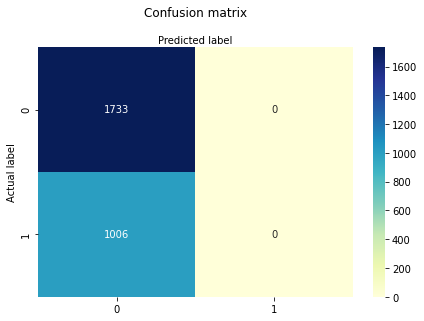

In [14]:
build_logistic_regression_model_one()

In [15]:
def build_optimized_lr_model_one():
    current_features_indices = [0, 6, 7, 8, 9, 10, 11, 12, 14, 15]
    
    features = daily_df.iloc[:, current_features_indices]
    response_variable = daily_df.iloc[:, -1]
    current_features = pd.get_dummies(features, prefix='ticker')

    X = current_features
    y = response_variable
    combined = current_features
    combined["rv"] = response_variable
    combined = clean_dataset(combined)
    current_features, response_variable = combined.iloc[:, :-1], combined.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(current_features, response_variable, test_size=0.25, random_state=42)

    model = LogisticRegression()
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [0.0001, 0.1, 0.2, 0.5, 0.8, 1, 1.5, 2.0, 5.0, 10.0, 15.0, 20.0, 50, 100, 200]
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(X_train, y_train)
    best_params = grid_result.best_params_
    best_c, best_solver, best_penalty = best_params["C"], best_params["solver"], best_params["penalty"]
    
    logreg = LogisticRegression(C=best_c, solver=best_solver, penalty=best_penalty)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    get_classification_metrics(y_test, y_pred, X_test, logreg)


Accuracy of logistic regression classifier on test set: 0.63
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.78      1733
         1.0       0.00      0.00      0.00      1006

    accuracy                           0.63      2739
   macro avg       0.32      0.50      0.39      2739
weighted avg       0.40      0.63      0.49      2739

Accuracy: 0.6327126688572472
Precision: 0.0
Recall: 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


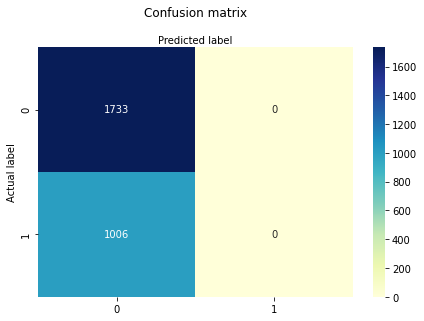

In [16]:
build_optimized_lr_model_one()

In [17]:
def build_optimized_lr_model_two():
    aapl, amzn, goog, googl, msft, tsla = get_data_split_by_ticker(daily_df)
    
    current_feature_indices = [6, 7, 8, 9, 10, 11, 12, 14, 15]
    
    aapl_features = aapl.iloc[:, current_feature_indices]
    aapl_rv = aapl.iloc[:, -1]
    aapl_combined = aapl_features
    aapl_combined["rv"] = aapl_rv
    aapl_combined = clean_dataset(aapl_combined)
    aapl_rv = aapl_combined.iloc[:, -1]
    aapl_features = aapl_combined.iloc[:, :-1]
    
    amzn_features = amzn.iloc[:, current_feature_indices]
    amzn_rv = amzn.iloc[:, -1]
    amzn_combined = amzn_features
    amzn_combined["rv"] = amzn_rv
    amzn_combined = clean_dataset(amzn_combined)
    amzn_rv = amzn_combined.iloc[:, -1]
    amzn_features = amzn_combined.iloc[:, :-1]

    goog_features = goog.iloc[:, current_feature_indices]
    goog_rv = goog.iloc[:, -1]
    goog_combined = goog_features
    goog_combined["rv"] = goog_rv
    goog_combined = clean_dataset(goog_combined)
    goog_rv = goog_combined.iloc[:, -1]
    goog_features = goog_combined.iloc[:, :-1]

    googl_features = googl.iloc[:, current_feature_indices]
    googl_rv = googl.iloc[:, -1]
    googl_combined = googl_features
    googl_combined["rv"] = googl_rv
    googl_combined = clean_dataset(googl_combined)
    googl_rv = googl_combined.iloc[:, -1]
    googl_features = googl_combined.iloc[:, :-1]

    msft_features = msft.iloc[:, current_feature_indices]
    msft_rv = msft.iloc[:, -1]
    msft_combined = msft_features
    msft_combined["rv"] = msft_rv
    msft_combined = clean_dataset(msft_combined)
    msft_rv = msft_combined.iloc[:, -1]
    msft_features = msft_combined.iloc[:, :-1]

    tsla_features = tsla.iloc[:, current_feature_indices]
    tsla_rv = tsla.iloc[:, -1]
    tsla_combined = tsla_features
    tsla_combined["rv"] = tsla_rv
    tsla_combined = clean_dataset(tsla_combined)
    tsla_rv = tsla_combined.iloc[:, -1]
    tsla_features = tsla_combined.iloc[:, :-1]  
    
    X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(aapl_features, aapl_rv, test_size=0.25, random_state=42)
    X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn = train_test_split(amzn_features, amzn_rv, test_size=0.25, random_state=42)
    X_train_goog, X_test_goog, y_train_goog, y_test_goog = train_test_split(goog_features, goog_rv, test_size=0.25, random_state=42)
    X_train_googl, X_test_googl, y_train_googl, y_test_googl = train_test_split(googl_features, googl_rv, test_size=0.25, random_state=42)
    X_train_msft, X_test_msft, y_train_msft, y_test_msft = train_test_split(msft_features, msft_rv, test_size=0.25, random_state=42)
    X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = train_test_split(tsla_features, tsla_rv, test_size=0.25, random_state=42)
    
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [0.0001, 0.1, 0.2, 0.5, 0.8, 1, 1.5, 2.0, 5.0, 10.0, 15.0, 20.0, 50, 100, 200]
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    
    aapl_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    aapl_grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=aapl_cv, scoring='accuracy',error_score=0)
    aapl_grid_result = aapl_grid_search.fit(X_train_aapl, y_train_aapl)
    aapl_best_params = aapl_grid_result.best_params_
    aapl_best_c, aapl_best_solver, aapl_best_penalty = aapl_best_params["C"], aapl_best_params["solver"], aapl_best_params["penalty"]
    
    reg_aapl = LogisticRegression(C=aapl_best_c, solver=aapl_best_solver, penalty=aapl_best_penalty)
    reg_aapl.fit(X_train_aapl, y_train_aapl)
    y_pred_aapl = reg_aapl.predict(X_test_aapl)

    amzn_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    amzn_grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=amzn_cv, scoring='accuracy',error_score=0)
    amzn_grid_result = amzn_grid_search.fit(X_train_amzn, y_train_amzn)
    amzn_best_params = amzn_grid_result.best_params_
    amzn_best_c, amzn_best_solver, amzn_best_penalty = amzn_best_params["C"], amzn_best_params["solver"], amzn_best_params["penalty"]

    reg_amzn = LogisticRegression(C=amzn_best_c, solver=amzn_best_solver, penalty=amzn_best_penalty).fit(X_train_amzn, y_train_amzn)
    y_pred_amzn = reg_amzn.predict(X_test_amzn)

    goog_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    goog_grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=goog_cv, scoring='accuracy',error_score=0)
    goog_grid_result = goog_grid_search.fit(X_train_goog, y_train_goog)
    goog_best_params = goog_grid_result.best_params_
    goog_best_c, goog_best_solver, goog_best_penalty = goog_best_params["C"], goog_best_params["solver"], goog_best_params["penalty"]

    reg_goog = LogisticRegression(C=goog_best_c, solver=goog_best_solver, penalty=goog_best_penalty).fit(X_train_goog, y_train_goog)
    y_pred_goog = reg_goog.predict(X_test_goog)

    googl_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    googl_grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=googl_cv, scoring='accuracy',error_score=0)
    googl_grid_result = googl_grid_search.fit(X_train_googl, y_train_googl)
    googl_best_params = googl_grid_result.best_params_
    googl_best_c, googl_best_solver, googl_best_penalty = googl_best_params["C"], googl_best_params["solver"], googl_best_params["penalty"]
    
    reg_googl = LogisticRegression(C=googl_best_c, solver=googl_best_solver, penalty=googl_best_penalty).fit(X_train_googl, y_train_googl)
    y_pred_googl = reg_googl.predict(X_test_googl)

    msft_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    msft_grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=msft_cv, scoring='accuracy',error_score=0)
    msft_grid_result = msft_grid_search.fit(X_train_msft, y_train_msft)
    msft_best_params = msft_grid_result.best_params_
    msft_best_c, msft_best_solver, msft_best_penalty = msft_best_params["C"], msft_best_params["solver"], msft_best_params["penalty"]
    
    reg_msft = LogisticRegression(C=msft_best_c, solver=msft_best_solver, penalty=msft_best_penalty).fit(X_train_msft, y_train_msft)
    y_pred_msft = reg_msft.predict(X_test_msft)

    tsla_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    tsla_grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=tsla_cv, scoring='accuracy',error_score=0)
    tsla_grid_result = tsla_grid_search.fit(X_train_tsla, y_train_tsla)
    tsla_best_params = tsla_grid_result.best_params_
    tsla_best_c, tsla_best_solver, tsla_best_penalty = tsla_best_params["C"], tsla_best_params["solver"], tsla_best_params["penalty"]

    reg_tsla = LogisticRegression(C=tsla_best_c, solver=tsla_best_solver, penalty=tsla_best_penalty).fit(X_train_tsla, y_train_tsla)
    y_pred_tsla = reg_tsla.predict(X_test_tsla)

    all_ticker_true = pd.concat([y_test_aapl, y_test_amzn, y_test_goog, y_test_googl, y_test_msft, y_test_tsla])
    all_ticker_pred = np.concatenate([y_pred_aapl, y_pred_amzn, y_pred_goog, y_pred_googl, y_pred_msft, y_pred_tsla])

    all_ticker_X_test = pd.concat([X_test_aapl, X_test_amzn, X_test_goog, X_test_googl, X_test_msft, X_test_tsla])
    
    get_classification_metrics(all_ticker_true, all_ticker_pred, all_ticker_X_test)
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorith

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Framewo

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Framewo

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Framewo

              precision    recall  f1-score   support

         0.0       0.66      0.96      0.78      1716
         1.0       0.69      0.16      0.26      1026

    accuracy                           0.66      2742
   macro avg       0.67      0.56      0.52      2742
weighted avg       0.67      0.66      0.58      2742

Accuracy: 0.6586433260393874
Precision: 0.6875
Recall: 0.1608187134502924


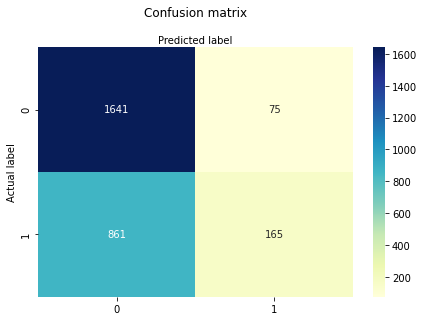

In [18]:
build_optimized_lr_model_two()

In [19]:
def build_logistic_regression_model_two():
    aapl, amzn, goog, googl, msft, tsla = get_data_split_by_ticker(daily_df)
    
    current_feature_indices = [6, 7, 8, 9, 10, 11, 12, 14, 15]
    
    aapl_features = aapl.iloc[:, current_feature_indices]
    aapl_rv = aapl.iloc[:, -1]
    aapl_combined = aapl_features
    aapl_combined["rv"] = aapl_rv
    aapl_combined = clean_dataset(aapl_combined)
    aapl_rv = aapl_combined.iloc[:, -1]
    aapl_features = aapl_combined.iloc[:, :-1]
    
    amzn_features = amzn.iloc[:, current_feature_indices]
    amzn_rv = amzn.iloc[:, -1]
    amzn_combined = amzn_features
    amzn_combined["rv"] = amzn_rv
    amzn_combined = clean_dataset(amzn_combined)
    amzn_rv = amzn_combined.iloc[:, -1]
    amzn_features = amzn_combined.iloc[:, :-1]

    goog_features = goog.iloc[:, current_feature_indices]
    goog_rv = goog.iloc[:, -1]
    goog_combined = goog_features
    goog_combined["rv"] = goog_rv
    goog_combined = clean_dataset(goog_combined)
    goog_rv = goog_combined.iloc[:, -1]
    goog_features = goog_combined.iloc[:, :-1]

    googl_features = googl.iloc[:, current_feature_indices]
    googl_rv = googl.iloc[:, -1]
    googl_combined = googl_features
    googl_combined["rv"] = googl_rv
    googl_combined = clean_dataset(googl_combined)
    googl_rv = googl_combined.iloc[:, -1]
    googl_features = googl_combined.iloc[:, :-1]

    msft_features = msft.iloc[:, current_feature_indices]
    msft_rv = msft.iloc[:, -1]
    msft_combined = msft_features
    msft_combined["rv"] = msft_rv
    msft_combined = clean_dataset(msft_combined)
    msft_rv = msft_combined.iloc[:, -1]
    msft_features = msft_combined.iloc[:, :-1]

    tsla_features = tsla.iloc[:, current_feature_indices]
    tsla_rv = tsla.iloc[:, -1]
    tsla_combined = tsla_features
    tsla_combined["rv"] = tsla_rv
    tsla_combined = clean_dataset(tsla_combined)
    tsla_rv = tsla_combined.iloc[:, -1]
    tsla_features = tsla_combined.iloc[:, :-1]  
    
    X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(aapl_features, aapl_rv, test_size=0.25, random_state=42)
    X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn = train_test_split(amzn_features, amzn_rv, test_size=0.25, random_state=42)
    X_train_goog, X_test_goog, y_train_goog, y_test_goog = train_test_split(goog_features, goog_rv, test_size=0.25, random_state=42)
    X_train_googl, X_test_googl, y_train_googl, y_test_googl = train_test_split(googl_features, googl_rv, test_size=0.25, random_state=42)
    X_train_msft, X_test_msft, y_train_msft, y_test_msft = train_test_split(msft_features, msft_rv, test_size=0.25, random_state=42)
    X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = train_test_split(tsla_features, tsla_rv, test_size=0.25, random_state=42)
    
    reg_aapl = LogisticRegression().fit(X_train_aapl, y_train_aapl)
    y_pred_aapl = reg_aapl.predict(X_test_aapl)

    reg_amzn = LogisticRegression().fit(X_train_amzn, y_train_amzn)
    y_pred_amzn = reg_amzn.predict(X_test_amzn)

    reg_goog = LogisticRegression().fit(X_train_goog, y_train_goog)
    y_pred_goog = reg_goog.predict(X_test_goog)

    reg_googl = LogisticRegression().fit(X_train_googl, y_train_googl)
    y_pred_googl = reg_googl.predict(X_test_googl)

    reg_msft = LogisticRegression().fit(X_train_msft, y_train_msft)
    y_pred_msft = reg_msft.predict(X_test_msft)

    reg_tsla = LogisticRegression().fit(X_train_tsla, y_train_tsla)
    y_pred_tsla = reg_tsla.predict(X_test_tsla)

    all_ticker_true = pd.concat([y_test_aapl, y_test_amzn, y_test_goog, y_test_googl, y_test_msft, y_test_tsla])
    all_ticker_pred = np.concatenate([y_pred_aapl, y_pred_amzn, y_pred_goog, y_pred_googl, y_pred_msft, y_pred_tsla])

    all_ticker_X_test = pd.concat([X_test_aapl, X_test_amzn, X_test_goog, X_test_googl, X_test_msft, X_test_tsla])
    
    get_classification_metrics(all_ticker_true, all_ticker_pred, all_ticker_X_test)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77      1716
         1.0       0.00      0.00      0.00      1026

    accuracy                           0.63      2742
   macro avg       0.31      0.50      0.38      2742
weighted avg       0.39      0.63      0.48      2742

Accuracy: 0.6258205689277899
Precision: 0.0
Recall: 0.0


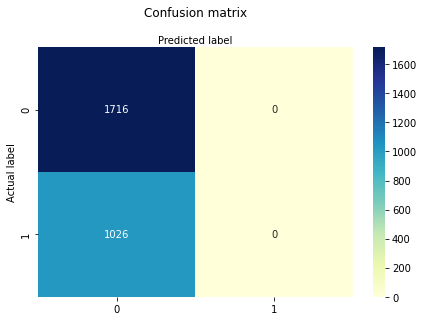

In [20]:
build_logistic_regression_model_two()

## Decision Trees

In [21]:
def build_dt_model_one():
    current_features_indices = [0, 6, 7, 8, 9, 10, 11, 12, 14, 15]

    features = daily_df.iloc[:, current_features_indices]
    response_variable = daily_df.iloc[:, -1]
    current_features = pd.get_dummies(features, prefix='ticker')
    
    X = current_features
    y = response_variable
    combined = current_features
    combined["rv"] = response_variable
    combined = clean_dataset(combined)
    current_features, response_variable = combined.iloc[:, :-1], combined.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(current_features, response_variable, test_size=0.25, random_state=42)
    
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=95)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    get_classification_metrics(y_test, y_pred, X_test)


              precision    recall  f1-score   support

         0.0       0.73      0.72      0.73      1733
         1.0       0.53      0.55      0.54      1006

    accuracy                           0.66      2739
   macro avg       0.63      0.63      0.63      2739
weighted avg       0.66      0.66      0.66      2739

Accuracy: 0.6568090543994158
Precision: 0.5319148936170213
Recall: 0.5467196819085487


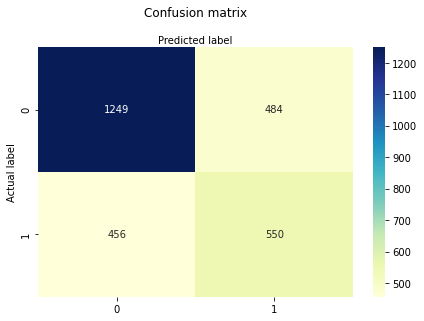

In [22]:
build_dt_model_one()

In [23]:
def build_dt_model_two():
    aapl, amzn, goog, googl, msft, tsla = get_data_split_by_ticker(daily_df)
    
    current_feature_indices = [6, 7, 8, 9, 10, 14]

    aapl_features = aapl.iloc[:, current_feature_indices]
    aapl_rv = aapl.iloc[:, -1]
    aapl_combined = aapl_features
    aapl_combined["rv"] = aapl_rv
    aapl_combined = clean_dataset(aapl_combined)
    aapl_rv = aapl_combined.iloc[:, -1]
    aapl_features = aapl_combined.iloc[:, :-1]
    
    amzn_features = amzn.iloc[:, current_feature_indices]
    amzn_rv = amzn.iloc[:, -1]
    amzn_combined = amzn_features
    amzn_combined["rv"] = amzn_rv
    amzn_combined = clean_dataset(amzn_combined)
    amzn_rv = amzn_combined.iloc[:, -1]
    amzn_features = amzn_combined.iloc[:, :-1]

    goog_features = goog.iloc[:, current_feature_indices]
    goog_rv = goog.iloc[:, -1]
    goog_combined = goog_features
    goog_combined["rv"] = goog_rv
    goog_combined = clean_dataset(goog_combined)
    goog_rv = goog_combined.iloc[:, -1]
    goog_features = goog_combined.iloc[:, :-1]

    googl_features = googl.iloc[:, current_feature_indices]
    googl_rv = googl.iloc[:, -1]
    googl_combined = googl_features
    googl_combined["rv"] = googl_rv
    googl_combined = clean_dataset(googl_combined)
    googl_rv = googl_combined.iloc[:, -1]
    googl_features = googl_combined.iloc[:, :-1]

    msft_features = msft.iloc[:, current_feature_indices]
    msft_rv = msft.iloc[:, -1]
    msft_combined = msft_features
    msft_combined["rv"] = msft_rv
    msft_combined = clean_dataset(msft_combined)
    msft_rv = msft_combined.iloc[:, -1]
    msft_features = msft_combined.iloc[:, :-1]

    tsla_features = tsla.iloc[:, current_feature_indices]
    tsla_rv = tsla.iloc[:, -1]
    tsla_combined = tsla_features
    tsla_combined["rv"] = tsla_rv
    tsla_combined = clean_dataset(tsla_combined)
    tsla_rv = tsla_combined.iloc[:, -1]
    tsla_features = tsla_combined.iloc[:, :-1]  
    
    X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(aapl_features, aapl_rv, test_size=0.25, random_state=42)
    X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn = train_test_split(amzn_features, amzn_rv, test_size=0.25, random_state=42)
    X_train_goog, X_test_goog, y_train_goog, y_test_goog = train_test_split(goog_features, goog_rv, test_size=0.25, random_state=42)
    X_train_googl, X_test_googl, y_train_googl, y_test_googl = train_test_split(googl_features, googl_rv, test_size=0.25, random_state=42)
    X_train_msft, X_test_msft, y_train_msft, y_test_msft = train_test_split(msft_features, msft_rv, test_size=0.25, random_state=42)
    X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = train_test_split(tsla_features, tsla_rv, test_size=0.25, random_state=42)
    
    dt_aapl = DecisionTreeClassifier(criterion="entropy", max_depth=95).fit(X_train_aapl, y_train_aapl)
    y_pred_aapl = dt_aapl.predict(X_test_aapl)

    dt_amzn = DecisionTreeClassifier(criterion="entropy", max_depth=95).fit(X_train_amzn, y_train_amzn)
    y_pred_amzn = dt_amzn.predict(X_test_amzn)

    dt_goog = DecisionTreeClassifier(criterion="entropy", max_depth=95).fit(X_train_goog, y_train_goog)
    y_pred_goog = dt_goog.predict(X_test_goog)

    dt_googl = DecisionTreeClassifier(criterion="entropy", max_depth=95).fit(X_train_googl, y_train_googl)
    y_pred_googl = dt_googl.predict(X_test_googl)


    dt_msft = DecisionTreeClassifier(criterion="entropy", max_depth=95).fit(X_train_msft, y_train_msft)
    y_pred_msft = dt_msft.predict(X_test_msft)

    dt_tsla = DecisionTreeClassifier(criterion="entropy", max_depth=95).fit(X_train_tsla, y_train_tsla)
    y_pred_tsla = dt_tsla.predict(X_test_tsla)


    all_ticker_true = pd.concat([y_test_aapl, y_test_amzn, y_test_goog, y_test_googl, y_test_msft, y_test_tsla])
    all_ticker_pred = np.concatenate([y_pred_aapl, y_pred_amzn, y_pred_goog, y_pred_googl, y_pred_msft, y_pred_tsla])

    
    all_ticker_X_test = pd.concat([X_test_aapl, X_test_amzn, X_test_goog, X_test_googl, X_test_msft, X_test_tsla])
    
    get_classification_metrics(all_ticker_true, all_ticker_pred, all_ticker_X_test)


In [24]:
def get_best_depth(input_X_train, input_y_train ):
    X_train, y_train = input_X_train, input_y_train
    dt_clf = Pipeline([
            ('clf', DecisionTreeClassifier()),])
    layers = [1,2,3,4,5,10,15,20,25,30,40,50,60,70,80,90,95,100,150,200]
    param_grid = {
        'clf__max_depth': layers}
    best_dt_clf = GridSearchCV(dt_clf,param_grid,cv = 5,scoring='accuracy')
    best_dt_clf.fit(X_train, y_train)
    results = pd.DataFrame(best_dt_clf.cv_results_,index = layers).sort_values(by="rank_test_score")
    best_params = results.iloc[0:1, :].reset_index(drop=True)["params"]
    best_max_depth = best_params[0]["clf__max_depth"]
    return best_max_depth    


In [25]:
def build_optimized_dt_model_one():
    current_features_indices = [0, 6, 7, 8, 9, 10, 11, 12, 14, 15]

    features = daily_df.iloc[:, current_features_indices]
    response_variable = daily_df.iloc[:, -1]
    current_features = pd.get_dummies(features, prefix='ticker')
    
    X = current_features
    y = response_variable
    combined = current_features
    combined["rv"] = response_variable
    combined = clean_dataset(combined)
    current_features, response_variable = combined.iloc[:, :-1], combined.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(current_features, response_variable, test_size=0.25, random_state=42)
    best_depth = get_best_depth(X_train, y_train)

    clf = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    get_classification_metrics(y_test, y_pred, X_test)


              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75      1733
         1.0       0.58      0.63      0.60      1006

    accuracy                           0.69      2739
   macro avg       0.67      0.68      0.68      2739
weighted avg       0.70      0.69      0.70      2739

Accuracy: 0.6940489229645856
Precision: 0.5760869565217391
Recall: 0.6322067594433399


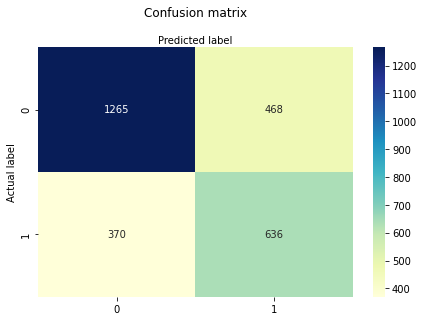

In [26]:
build_optimized_dt_model_one()

In [27]:
def build_optimized_dt_model_two():

    aapl, amzn, goog, googl, msft, tsla = get_data_split_by_ticker(daily_df)
    
    current_feature_indices = [6, 7, 8, 9, 10, 14]

    aapl_features = aapl.iloc[:, current_feature_indices]
    aapl_rv = aapl.iloc[:, -1]
    aapl_combined = aapl_features
    aapl_combined["rv"] = aapl_rv
    aapl_combined = clean_dataset(aapl_combined)
    aapl_rv = aapl_combined.iloc[:, -1]
    aapl_features = aapl_combined.iloc[:, :-1]
    
    amzn_features = amzn.iloc[:, current_feature_indices]
    amzn_rv = amzn.iloc[:, -1]
    amzn_combined = amzn_features
    amzn_combined["rv"] = amzn_rv
    amzn_combined = clean_dataset(amzn_combined)
    amzn_rv = amzn_combined.iloc[:, -1]
    amzn_features = amzn_combined.iloc[:, :-1]

    goog_features = goog.iloc[:, current_feature_indices]
    goog_rv = goog.iloc[:, -1]
    goog_combined = goog_features
    goog_combined["rv"] = goog_rv
    goog_combined = clean_dataset(goog_combined)
    goog_rv = goog_combined.iloc[:, -1]
    goog_features = goog_combined.iloc[:, :-1]

    googl_features = googl.iloc[:, current_feature_indices]
    googl_rv = googl.iloc[:, -1]
    googl_combined = googl_features
    googl_combined["rv"] = googl_rv
    googl_combined = clean_dataset(googl_combined)
    googl_rv = googl_combined.iloc[:, -1]
    googl_features = googl_combined.iloc[:, :-1]

    msft_features = msft.iloc[:, current_feature_indices]
    msft_rv = msft.iloc[:, -1]
    msft_combined = msft_features
    msft_combined["rv"] = msft_rv
    msft_combined = clean_dataset(msft_combined)
    msft_rv = msft_combined.iloc[:, -1]
    msft_features = msft_combined.iloc[:, :-1]

    tsla_features = tsla.iloc[:, current_feature_indices]
    tsla_rv = tsla.iloc[:, -1]
    tsla_combined = tsla_features
    tsla_combined["rv"] = tsla_rv
    tsla_combined = clean_dataset(tsla_combined)
    tsla_rv = tsla_combined.iloc[:, -1]
    tsla_features = tsla_combined.iloc[:, :-1]  
    
    X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(aapl_features, aapl_rv, test_size=0.25, random_state=42)
    X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn = train_test_split(amzn_features, amzn_rv, test_size=0.25, random_state=42)
    X_train_goog, X_test_goog, y_train_goog, y_test_goog = train_test_split(goog_features, goog_rv, test_size=0.25, random_state=42)
    X_train_googl, X_test_googl, y_train_googl, y_test_googl = train_test_split(googl_features, googl_rv, test_size=0.25, random_state=42)
    X_train_msft, X_test_msft, y_train_msft, y_test_msft = train_test_split(msft_features, msft_rv, test_size=0.25, random_state=42)
    X_train_tsla, X_test_tsla, y_train_tsla, y_test_tsla = train_test_split(tsla_features, tsla_rv, test_size=0.25, random_state=42)

    aapl_best_depth = get_best_depth(X_train_aapl, y_train_aapl)
    dt_aapl = DecisionTreeClassifier(criterion="entropy", max_depth=aapl_best_depth).fit(X_train_aapl, y_train_aapl)
    y_pred_aapl = dt_aapl.predict(X_test_aapl)

    amzn_best_depth = get_best_depth(X_train_amzn, y_train_amzn)
    dt_amzn = DecisionTreeClassifier(criterion="entropy", max_depth=amzn_best_depth).fit(X_train_amzn, y_train_amzn)
    y_pred_amzn = dt_amzn.predict(X_test_amzn)

    goog_best_depth = get_best_depth(X_train_goog, y_train_goog)
    dt_goog = DecisionTreeClassifier(criterion="entropy", max_depth=goog_best_depth).fit(X_train_goog, y_train_goog)
    y_pred_goog = dt_goog.predict(X_test_goog)

    googl_best_depth = get_best_depth(X_train_googl, y_train_googl)
    dt_googl = DecisionTreeClassifier(criterion="entropy", max_depth=googl_best_depth).fit(X_train_googl, y_train_googl)
    y_pred_googl = dt_googl.predict(X_test_googl)

    msft_best_depth = get_best_depth(X_train_msft, y_train_msft)
    dt_msft = DecisionTreeClassifier(criterion="entropy", max_depth=msft_best_depth).fit(X_train_msft, y_train_msft)
    y_pred_msft = dt_msft.predict(X_test_msft)

    tsla_best_depth = get_best_depth(X_train_tsla, y_train_tsla)
    dt_tsla = DecisionTreeClassifier(criterion="entropy", max_depth=tsla_best_depth).fit(X_train_tsla, y_train_tsla)
    y_pred_tsla = dt_tsla.predict(X_test_tsla)

    all_ticker_true = pd.concat([y_test_aapl, y_test_amzn, y_test_goog, y_test_googl, y_test_msft, y_test_tsla])
    all_ticker_pred = np.concatenate([y_pred_aapl, y_pred_amzn, y_pred_goog, y_pred_googl, y_pred_msft, y_pred_tsla])
    
    all_ticker_X_test = pd.concat([X_test_aapl, X_test_amzn, X_test_goog, X_test_googl, X_test_msft, X_test_tsla])
    
    get_classification_metrics(all_ticker_true, all_ticker_pred, all_ticker_X_test)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76      1716
         1.0       0.60      0.51      0.55      1026

    accuracy                           0.69      2742
   macro avg       0.66      0.65      0.65      2742
weighted avg       0.68      0.69      0.68      2742

Accuracy: 0.687454412837345
Precision: 0.5972382048331415
Recall: 0.5058479532163743


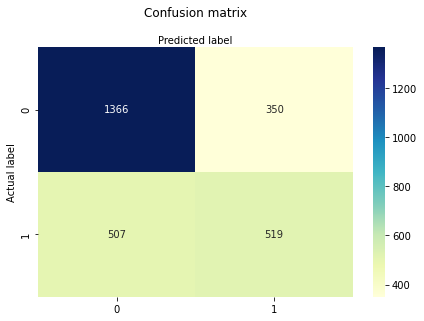

In [28]:
build_optimized_dt_model_two()

In [29]:
# NEXT STEPS: 
# - hyperparameter tuning
# - operationalization
# - add in S&P 500 data